# Introduction

Takes exploratory data and fits variations of the DDM.

DDM: average-signal

Details: Take every signal that the subject saw in a trial, and average their values. Feed that into a DDM as a time-invariant signal.

## Preamble

In [1]:
# Install (package verification, PyDDM, timer, parallelization)
#!pip3 install paranoid-scientist
#!pip3 install pyddm
#!pip3 install pytictoc  
#!pip3 install pathos  
#!pip3 install pandas
#!pip3 install numpy
#!pip3 install matplotlib

# Python 3.9.13

In [2]:
# Libraries
import os
from pytictoc import TicToc
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import pyddm as ddm
from pyddm import Model, Sample, FitResult, Fittable, Fitted, ICPoint, set_N_cpus
from pyddm.models import NoiseConstant, BoundConstant, OverlayChain, OverlayNonDecision, OverlayUniformMixture, LossRobustBIC
from pyddm.functions import fit_adjust_model, display_model
import pyddm.plot

In [3]:
# Directories
datadir = "/Users/ella/Desktop/2023-ddm-sampling-weights/data/processed_data/exploratory.csv"
tempdir = "/Users/ella/Desktop/2023-ddm-sampling-weights/analysis/outputs/temp/"

In [4]:
# Parallel settings
ncpu = multiprocessing.cpu_count()-1 # always save one core
ncpu

5

In [5]:
# Choose what models to fit, if any. Otherwise, load previous results.
fit_averagestimulus_model = False
fit_momenttomoment_model = False
fit_stimulusvalue_model = False
fit_stimulusmagnitude_model = False # fail to fit
fit_distortion_model = False # fail to fit
fit_uniquestimulus_model = True

# Do you want a disgusting amount of feedback from model fitting or nah?
verbose_fitting = False

## Import and Clean Raw Data

rawdata_in: odd trials used for in-sample data for model fitting.

rawdata_out: even trials used for out-sample data for model predictions.

In [6]:
# Import data
rawdata = pd.read_csv(datadir)
rawdata = rawdata.rename(columns={"subj":"subject", "rxn_time":"rt"})

# Turn choice into numeric (1=Y, 0=N)
mapping = {"YES":1, "NO":0}
rawdata = rawdata.replace({"choice":mapping})

# Drop no-response trials.
rawdata = rawdata[~np.isnan(rawdata['choice'])]

# Convert rt from ms to s
rawdata.rt = rawdata.rt/1000

# Odd trials -> in-sample. Even trials -> out-sample.
ind = rawdata.trial % 2 != 0
rawdata_in = pd.DataFrame(data=rawdata[ind])
rawdata_out = pd.DataFrame(data=rawdata[~ind])
print(rawdata_in[["subject","trial"]].head(1))
print(rawdata_in[["subject","trial"]].tail(1))
print(rawdata_out[["subject","trial"]].head(1))
print(rawdata_out[["subject","trial"]].tail(1))

   subject  trial
0        1      1
       subject  trial
60659       25    299
   subject  trial
3        1      2
       subject  trial
60669       25    300


---
# Time-Invariant DDM: evidence = avg stimulus value

## Transform data

Average stimulus is rounded to the tenth decimal. This introduces noise into the fitting process, but it significantly speeds up the fitting process. Fitting is parallelized by spliting the job up by different average stimulus values. Reducing the number of unique average stimulus values allows for more efficient parallelization.

I'm taking this shortcut here because I think this is a poor way to estimate the DDM anyways. Average stimulus should be correlated to the reaction time, since the average is calculated according to how many stimuli the subject saw, which depends on their reaction time.

Data
               subject  trial  choice      rt  machine  stim
subject trial                                               
1       1            1      1     1.0  0.9739        1   2.0
        3            1      3     0.0  1.3940       -2  -1.8
        5            1      5     0.0  4.0545       -1  -0.8
        7            1      7     0.0  1.2802        0   0.1
        9            1      9     1.0  5.8468        2   1.0
        11           1     11     0.0  2.3290       -1  -0.4
Unique Stimulus Values
[-2.2 -2.1 -2.  -1.9 -1.8 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9
 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5
  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7  2.8  2.9]
How many unique values?
52


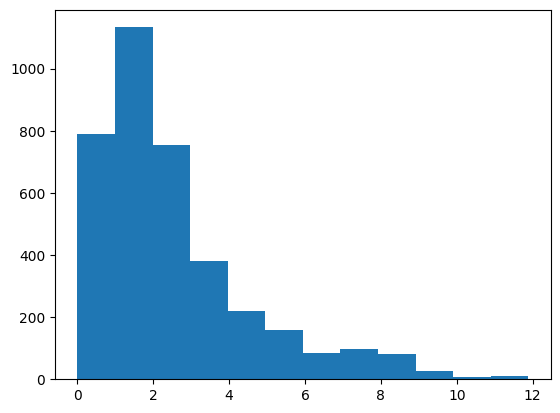

In [7]:
# Don't touch the raw data.
data = rawdata_in

# Get the first entry per subject-trial combo for most variables. Get the average stimulus variable.
data = data.groupby(["subject","trial"]).agg({"subject":'first', "trial":"first", "choice":"first", "rt":"first", "machine":"first", "stim":"mean"})

# Round average stimulus to tenth place.
data.stim = np.round(data.stim, 1)

# Display
plt.hist(data["rt"],bins=12)
print("Data")
print(data.head(6))
print("Unique Stimulus Values")
print(np.sort(data.stim.unique()))
print("How many unique values?")
print(len(data.stim.unique()))

## Fit the average stimulus DDM

In [8]:
# Create a drift subclass so drift can vary with stimulus.
class DriftStim(ddm.models.Drift):
  name = "Drift depends linearly on stimulus value"
  required_parameters = ["driftstim"] # Parameters we want to include in the model.
  required_conditions = ["stim"] # The column in your sample data that modulates the parameters above.
  def get_drift(self, conditions, **kwargs):
    return self.driftstim * conditions["stim"]

# Define the model.
model_as = Model(name="Time invariant drift modulated by average signal",
                 drift=DriftStim(driftstim=Fittable(minval=-1, maxval=4)),
                 noise=NoiseConstant(noise=Fittable(minval=.001, maxval=2)),
                 bound=BoundConstant(B=1),
                 IC=ICPoint(x0=Fittable(minval=-.99, maxval=.99)),
                 overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.1)),
                 dx=.01, dt=.01, T_dur=12,  # dx: spatial grid for evidence space (-B to B, in dx bins), dt: time step in s. See Shin et al 2022 Fig 4 for why I set dx=dt.
                 choice_names=("Yes","No"))

In [9]:
# Only run this if specified at the start. Otherwise, just load pre-saved weights.
if fit_averagestimulus_model:
    print("DDM: Time Invariant Drift")

    # Iterate through subjects.
    subnums = np.sort(data.subject.unique())
    for subnum in subnums:

        # Progress tracker.
        print("============================================================================")
        print("Subject " + str(subnum))

        # Subset the data.
        subdata = data[data["subject"]==subnum]

        # Create a sample object from our data. Sample objects are the standard input for pyDDM fitting functions.
        ddm_data = Sample.from_pandas_dataframe(subdata, rt_column_name="rt", choice_column_name="choice", choice_names=("Yes","No"))

        # Fit the model and show it off. Keep track of how long it took to estimate the parameters.
        clock = TicToc() # Timer
        clock.tic()
        set_N_cpus(ncpu) # Parallelize
        fit_model_as = fit_adjust_model(sample=ddm_data, model=model_as,
                                        fitting_method="differential_evolution",
                                        lossfunction=LossRobustBIC,
                                        verbose=verbose_fitting)
        clock.toc("Fitting subject " + str(subnum) + " took")
        display_model(fit_model_as)

        # Save
        filename = tempdir + "fit_model_as_" + str(subnum) + ".txt"
        with open(filename, "w") as f:
          f.write(repr(fit_model_as))

## Extract parameters and BIC for the model objects

In [10]:
# Placeholders
model_as_bic = []
model_as_drift = []
model_as_noise = []
model_as_bias = []
model_as_ndt = []

# Iterate through subjects.
subnums = np.sort(data.subject.unique())
for subnum in subnums:
    
    # Load
    filename = tempdir + "fit_model_as_" + str(subnum) + ".txt"
    with open(filename, "r") as f:
        model_loaded = eval(f.read())

    # Negative Log Likelihood.
    model_as_bic.append(model_loaded.get_fit_result().value())
    
    # Fitted parameters.
    model_as_drift.append(model_loaded.parameters()['drift']['driftstim'])
    model_as_noise.append(model_loaded.parameters()['noise']['noise'])
    model_as_bias.append(model_loaded.parameters()['IC']['x0'])
    model_as_ndt.append(model_loaded.parameters()['overlay']['nondectime'])
    
d = {'bic':model_as_bic, "drift":model_as_drift, "noise":model_as_noise, "bias":model_as_bias, "ndt":model_as_ndt}
indiv_model_as = pd.DataFrame(data=d)
indiv_model_as

,bic,drift,noise,bias,ndt
0,443.576431,0.403546,0.368876,-0.278941,0.094668
1,875.981638,0.096721,0.194593,-0.066322,0.083425
2,550.617604,0.263634,0.274453,-0.224842,0.095580
3,698.004648,0.163944,0.192467,-0.096242,0.099018
4,780.101301,0.141472,0.239375,-0.083149,0.097455
5,506.062985,0.410498,0.876866,-0.269408,0.020913
6,1323.869324,0.094724,0.802427,0.435531,0.000836
7,477.307972,0.380505,0.686332,-0.126680,0.095847
8,527.372644,0.372288,0.563915,-0.045598,0.084873
9,283.728724,0.711251,0.882524,-0.224483,0.092215


## Means of BIC and Estimates

Confidence intervals assume normal distribution.

In [11]:
summstats_model_as = pd.DataFrame(data={"mean":indiv_model_as.mean(), 
                                        "se":indiv_model_as.sem(),
                                        "ci_lower":indiv_model_as.mean()-1.96*indiv_model_as.sem(),
                                        "ci_upper":indiv_model_as.mean()+1.96*indiv_model_as.sem()}).T
summstats_model_as

,bic,drift,noise,bias,ndt
mean,537.868875,0.363206,0.495371,-0.136397,0.086764
se,45.113070,0.033230,0.046792,0.033858,0.004735
ci_lower,449.447258,0.298075,0.403658,-0.202760,0.077484
ci_upper,626.290492,0.428336,0.587084,-0.070035,0.096045


## Save

In [12]:
table_model_as = pd.concat([indiv_model_as, summstats_model_as])
filename = tempdir + "table_model_as.txt"
with open(filename, "w") as f:
  f.write(repr(table_model_as))

---
# Moment-to-Moment DDM: evidence depends on current stimulus

## Transform data

In [13]:
# Don't mess with the rawdata.
data = pd.DataFrame(data=rawdata_in)

# Transform the data from long to wide, then combine the new stim columns into one tuple.
datawide = data
datawide["stimnum"] = datawide.groupby(["subject","trial"]).cumcount()+1
datalong = datawide.pivot(index=['subject','trial'], columns='stimnum', values='stim')
stim_list = datalong.apply(list, axis=1)
ind = 0
for l in stim_list:
    row = np.array(stim_list.iloc[ind], dtype=np.float32)
    stim_list.iloc[ind] = tuple(row[~np.isnan(row)])
    ind += 1
data = data.groupby(["subject","trial"], as_index=False).first()
data["stim_list"] = stim_list.values
data

,subject,trial,choice,rt,machine,StimuliSeen,stim,S0,S1,S2,Selse,stimnum,stim_list
0,1,1,1.0,0.9739,1,3,2.875,1.125,1.875,2.875,NaN,1,"(2.875, 1.875, 1.125)"
1,1,3,0.0,1.3940,-2,4,0.875,-2.375,-2.875,-2.875,0.875,1,"(0.875, -2.875, -2.875, -2.375)"
2,1,5,0.0,4.0545,-1,13,0.375,-2.625,-2.875,-0.875,0.375,1,"(0.375, 1.375, -2.875, -2.875, 0.125, -0.875, ..."
3,1,7,0.0,1.2802,0,4,0.875,2.875,-0.625,-2.625,0.875,1,"(0.875, -2.625, -0.625, 2.875)"
4,1,9,1.0,5.8468,2,19,0.625,2.875,0.375,1.375,2.125,1,"(0.625, 2.875, 1.625, 0.375, 2.875, 1.375, 2.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3740,25,291,0.0,2.2235,-1,7,2.875,-2.875,-1.625,-2.125,-2.875,1,"(2.875, -1.375, -0.125, -2.875, -2.125, -1.625..."
3741,25,293,0.0,1.5562,-2,5,0.625,-1.625,-2.875,-1.875,-0.125,1,"(0.625, -0.125, -1.875, -2.875, -1.625)"
3742,25,295,0.0,1.2840,0,4,0.375,0.875,-1.375,0.375,0.375,1,"(0.375, 0.375, -1.375, 0.875)"
3743,25,297,0.0,1.6909,2,5,0.125,2.625,0.625,2.875,-0.375,1,"(0.125, -0.375, 2.875, 0.625, 2.625)"


## Fit the Moment-to-Moment DDM

In [14]:
# Create a drift subclass so drift can vary with stimulus.
class DriftMomentToMoment(ddm.Drift):
    name = "time varying drift depends on moment-to-moment evidence"
    BINSIZE = .3 # 300 ms per bin
    required_parameters = ['driftrate'] # How much to scale moment-to-moment drift.
    required_conditions = ['stim_list', 'machine'] # Should be a tuple of values which modulate the moment-to-moment drift.
    def get_drift(self, t, conditions, **kwargs):
        bin_number = int(t//self.BINSIZE) # Which bin are we currently in?
        n_bins = len(conditions['stim_list']) # Total number of bins for this condition.
        # If we are currently in a bin which exceeds the total bins, fix to the slot machine average.
        if bin_number < n_bins:
            signal = conditions['stim_list'][bin_number]
        else:
            signal = conditions['machine']
        # Compute the moment-to-moment drift
        return self.driftrate * signal

# Define the model.
model_mm = Model(name="time variant drift modulated by moment-to-moment evidence",
                 drift=DriftMomentToMoment(driftrate=Fittable(minval=-1, maxval=4)),
                 noise=NoiseConstant(noise=Fittable(minval=.001, maxval=2)),
                 bound=BoundConstant(B=1),
                 IC=ICPoint(x0=Fittable(minval=-.99, maxval=.99)),
                 overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.1)),
                 dx=.01, dt=.01, T_dur=12,  # dx: spatial grid for evidence space (-B to B, in dx bins), dt: time step in s. See Shin et al 2022 Fig 4 for why I set dx=dt.
                 choice_names=("Yes","No"))

In [15]:
# Only run this if specified at the start. Otherwise, just load pre-saved weights.
if fit_momenttomoment_model:
    print("DDM: Time Variant, Moment-to-Moment Drift")

    # Iterate through subjects.
    subnums = np.sort(data.subject.unique())
    for subnum in subnums:

        # Progress tracker.
        print("============================================================================")
        print("Subject " + str(subnum))

        # Subset the data.
        subdata = data[data["subject"]==subnum]

        # Create a sample object from our data. Sample objects are the standard input for pyDDM fitting functions.
        ddm_data = Sample.from_pandas_dataframe(subdata, rt_column_name="rt", choice_column_name="choice", choice_names=("Yes","No"))

        # Fit the model and show it off. Keep track of how long it took to estimate the parameters.
        clock = TicToc() # Timer
        clock.tic()
        set_N_cpus(ncpu) # Parallelize
        fit_model_mm = fit_adjust_model(sample=ddm_data, model=model_mm,
                                        fitting_method="differential_evolution",
                                        lossfunction=LossRobustBIC,
                                        verbose=verbose_fitting)
        clock.toc("Fitting subject " + str(subnum) + " took")
        display_model(fit_model_mm)

        # Save
        filename = tempdir + "fit_model_mm_" + str(subnum) + ".txt"
        with open(filename, "w") as f:
          f.write(repr(fit_model_mm))

## Extract parameters and BIC for the model objects

In [16]:
# Placeholders
model_mm_bic = []
model_mm_drift = []
model_mm_noise = []
model_mm_bias = []
model_mm_ndt = []

# Iterate through subjects.
subnums = np.sort(data.subject.unique())
for subnum in subnums:
    
    # Load
    filename = tempdir + "fit_model_mm_" + str(subnum) + ".txt"
    with open(filename, "r") as f:
        model_loaded = eval(f.read())

    # Negative Log Likelihood.
    model_mm_bic.append(model_loaded.get_fit_result().value())
    
    # Fitted parameters.
    model_mm_drift.append(model_loaded.parameters()['drift']['driftrate'])
    model_mm_noise.append(model_loaded.parameters()['noise']['noise'])
    model_mm_bias.append(model_loaded.parameters()['IC']['x0'])
    model_mm_ndt.append(model_loaded.parameters()['overlay']['nondectime'])
    
d = {'bic':model_mm_bic, "drift":model_mm_drift, "noise":model_mm_noise, "bias":model_mm_bias, "ndt":model_mm_ndt}
indiv_model_mm = pd.DataFrame(data=d)
indiv_model_mm

,bic,drift,noise,bias,ndt
0,445.874866,0.346057,0.426545,-0.238529,0.095246
1,859.529666,0.094835,0.197338,-0.068017,0.075893
2,542.243539,0.252691,0.298495,-0.225579,0.091235
3,687.740087,0.157038,0.202863,-0.088741,0.055150
4,771.773849,0.135681,0.251095,-0.109692,0.094115
5,491.102162,0.419999,0.887037,-0.282471,0.044468
6,1149.882252,0.093583,0.711026,0.225663,0.000392
7,472.927255,0.351923,0.688577,-0.151661,0.094010
8,561.063172,0.301981,0.550459,-0.025231,0.023366
9,273.322166,0.732272,0.881335,-0.273638,0.092230


## Means of BIC and Estimates

In [17]:
summstats_model_mm = pd.DataFrame(data={"mean":indiv_model_mm.mean(), 
                                        "se":indiv_model_mm.sem(),
                                        "ci_lower":indiv_model_mm.mean()-1.96*indiv_model_mm.sem(),
                                        "ci_upper":indiv_model_mm.mean()+1.96*indiv_model_mm.sem()}).T
summstats_model_mm

,bic,drift,noise,bias,ndt
mean,532.649404,0.342807,0.507872,-0.157882,0.079366
se,39.486029,0.033071,0.045073,0.030149,0.006004
ci_lower,455.256788,0.277988,0.419529,-0.216974,0.067598
ci_upper,610.042020,0.407626,0.596215,-0.098789,0.091133


## Save

In [18]:
table_model_mm = pd.concat([indiv_model_mm, summstats_model_mm])
filename = tempdir + "table_model_mm.txt"
with open(filename, "w") as f:
  f.write(repr(table_model_mm))

---
# Stimulus-Value DDM: drift rate depends linearly on the stimulus value

## Transform Data

In [19]:
# Don't mess with the rawdata.
data = pd.DataFrame(data=rawdata_in)

# Transform the data from long to wide, then combine the new stim columns into one tuple.
datawide = data
datawide["stimnum"] = datawide.groupby(["subject","trial"]).cumcount()+1
datalong = datawide.pivot(index=['subject','trial'], columns='stimnum', values='stim')
stim_list = datalong.apply(list, axis=1)
ind = 0
for l in stim_list:
    row = np.array(stim_list.iloc[ind], dtype=np.float32)
    stim_list.iloc[ind] = tuple(row[~np.isnan(row)])
    ind += 1
data = data.groupby(["subject","trial"], as_index=False).first()
data["stim_list"] = stim_list.values
data

,subject,trial,choice,rt,machine,StimuliSeen,stim,S0,S1,S2,Selse,stimnum,stim_list
0,1,1,1.0,0.9739,1,3,2.875,1.125,1.875,2.875,NaN,1,"(2.875, 1.875, 1.125)"
1,1,3,0.0,1.3940,-2,4,0.875,-2.375,-2.875,-2.875,0.875,1,"(0.875, -2.875, -2.875, -2.375)"
2,1,5,0.0,4.0545,-1,13,0.375,-2.625,-2.875,-0.875,0.375,1,"(0.375, 1.375, -2.875, -2.875, 0.125, -0.875, ..."
3,1,7,0.0,1.2802,0,4,0.875,2.875,-0.625,-2.625,0.875,1,"(0.875, -2.625, -0.625, 2.875)"
4,1,9,1.0,5.8468,2,19,0.625,2.875,0.375,1.375,2.125,1,"(0.625, 2.875, 1.625, 0.375, 2.875, 1.375, 2.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3740,25,291,0.0,2.2235,-1,7,2.875,-2.875,-1.625,-2.125,-2.875,1,"(2.875, -1.375, -0.125, -2.875, -2.125, -1.625..."
3741,25,293,0.0,1.5562,-2,5,0.625,-1.625,-2.875,-1.875,-0.125,1,"(0.625, -0.125, -1.875, -2.875, -1.625)"
3742,25,295,0.0,1.2840,0,4,0.375,0.875,-1.375,0.375,0.375,1,"(0.375, 0.375, -1.375, 0.875)"
3743,25,297,0.0,1.6909,2,5,0.125,2.625,0.625,2.875,-0.375,1,"(0.125, -0.375, 2.875, 0.625, 2.625)"


## Fit the Stimulus-Value DDM

In [20]:
# Create a drift subclass so drift can vary with stimulus.
class DriftStimulusValue(ddm.Drift):
    name = "drift rate depends linearly on stimulus value"
    BINSIZE = .3 # 300 ms per bin
    required_parameters = ['driftrate', 'driftratedelta'] # How much to scale moment-to-moment drift.
    required_conditions = ['stim_list', 'machine'] # Should be a tuple of values which modulate the moment-to-moment drift.
    def get_drift(self, t, conditions, **kwargs):
        bin_number = int(t//self.BINSIZE) # Which bin are we currently in?
        n_bins = len(conditions['stim_list']) # Total number of bins for this condition.
        # If we are currently in a bin which exceeds the total bins, fix to the slot machine average.
        if bin_number < n_bins:
            signal = conditions['stim_list'][bin_number]
        else:
            signal = conditions['machine']
        # Compute the moment-to-moment drift
        return (self.driftrate + (self.driftratedelta*signal)) * signal

# Define the model.
model_sv = Model(name="drift rate depends linearly on stimulus value",
                 drift=DriftStimulusValue(driftrate=Fittable(minval=-1, maxval=4), driftratedelta=Fittable(minval=-2, maxval=2)),
                 noise=NoiseConstant(noise=Fittable(minval=.001, maxval=2)),
                 bound=BoundConstant(B=1),
                 IC=ICPoint(x0=Fittable(minval=-.99, maxval=.99)),
                 overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.1)),
                 dx=.01, dt=.01, T_dur=12,  # dx: spatial grid for evidence space (-B to B, in dx bins), dt: time step in s. See Shin et al 2022 Fig 4 for why I set dx=dt.
                 choice_names=("Yes","No"))

In [21]:
# Only run this if specified at the start. Otherwise, just load pre-saved weights.
if fit_stimulusvalue_model:
    print("DDM: drift rate is linear in stimulus value")

    # Iterate through subjects.
    subnums = np.sort(data.subject.unique())
    for subnum in subnums:

        # Progress tracker.
        print("============================================================================")
        print("Subject " + str(subnum))

        # Subset the data.
        subdata = data[data["subject"]==subnum]

        # Create a sample object from our data. Sample objects are the standard input for pyDDM fitting functions.
        ddm_data = Sample.from_pandas_dataframe(subdata, rt_column_name="rt", choice_column_name="choice", choice_names=("Yes","No"))

        # Fit the model and show it off. Keep track of how long it took to estimate the parameters.
        clock = TicToc() # Timer
        clock.tic()
        set_N_cpus(ncpu) # Parallelize
        fit_model_sd = fit_adjust_model(sample=ddm_data, model=model_sv,
                                        fitting_method="differential_evolution",
                                        lossfunction=LossRobustBIC,
                                        verbose=verbose_fitting)
        clock.toc("Fitting subject " + str(subnum) + " took")
        display_model(fit_model_sv)

        # Save
        filename = tempdir + "fit_model_sv_" + str(subnum) + ".txt"
        with open(filename, "w") as f:
          f.write(repr(fit_model_sv))

## Extract parameter estimates and BIC

In [22]:
# Placeholders
model_sv_bic = []
model_sv_drift = []
model_sv_driftdelta = []
model_sv_noise = []
model_sv_bias = []
model_sv_ndt = []

# Iterate through subjects.
subnums = np.sort(data.subject.unique())
for subnum in subnums:
    
    # Load
    filename = tempdir + "fit_model_sv_" + str(subnum) + ".txt"
    with open(filename, "r") as f:
        model_loaded = eval(f.read())

    # Negative Log Likelihood.
    model_sv_bic.append(model_loaded.get_fit_result().value())
    
    # Fitted parameters.
    model_sv_drift.append(model_loaded.parameters()['drift']['driftrate'])
    model_sv_driftdelta.append(model_loaded.parameters()['drift']['driftratedelta'])
    model_sv_noise.append(model_loaded.parameters()['noise']['noise'])
    model_sv_bias.append(model_loaded.parameters()['IC']['x0'])
    model_sv_ndt.append(model_loaded.parameters()['overlay']['nondectime'])
    
d = {'bic':model_sv_bic, "drift":model_sv_drift, "driftdelta":model_sv_driftdelta, "noise":model_sv_noise, "bias":model_sv_bias, "ndt":model_sv_ndt}
indiv_model_sv = pd.DataFrame(data=d)
indiv_model_sv

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ella/Desktop/2023-ddm-sampling-weights/analysis/outputs/temp/fit_model_sv_1.txt'

## Means of the estimates and BIC

In [ ]:
summstats_model_sv = pd.DataFrame(data={"mean":indiv_model_sv.mean(), 
                                        "se":indiv_model_sv.sem(),
                                        "ci_lower":indiv_model_sv.mean()-1.96*indiv_model_sv.sem(),
                                        "ci_upper":indiv_model_sv.mean()+1.96*indiv_model_sv.sem()}).T
summstats_model_sv

## Save

In [ ]:
table_model_sv = pd.concat([indiv_model_sv, summstats_model_sv])
filename = tempdir + "table_model_sv.txt"
with open(filename, "w") as f:
  f.write(repr(table_model_sv))

---
# Stimulus-Magnitude DDM: drift rate scales with magnitude of stimulus

## Transform data

In [23]:
# Don't mess with the rawdata.
data = pd.DataFrame(data=rawdata_in)

# Transform the data from long to wide, then combine the new stim columns into one tuple.
datawide = data
datawide["stimnum"] = datawide.groupby(["subject","trial"]).cumcount()+1
datalong = datawide.pivot(index=['subject','trial'], columns='stimnum', values='stim')
stim_list = datalong.apply(list, axis=1)
ind = 0
for l in stim_list:
    row = np.array(stim_list.iloc[ind], dtype=np.float32)
    stim_list.iloc[ind] = tuple(row[~np.isnan(row)])
    ind += 1
data = data.groupby(["subject","trial"], as_index=False).first()
data["stim_list"] = stim_list.values
data

,subject,trial,choice,rt,machine,StimuliSeen,stim,S0,S1,S2,Selse,stimnum,stim_list
0,1,1,1.0,0.9739,1,3,2.875,1.125,1.875,2.875,NaN,1,"(2.875, 1.875, 1.125)"
1,1,3,0.0,1.3940,-2,4,0.875,-2.375,-2.875,-2.875,0.875,1,"(0.875, -2.875, -2.875, -2.375)"
2,1,5,0.0,4.0545,-1,13,0.375,-2.625,-2.875,-0.875,0.375,1,"(0.375, 1.375, -2.875, -2.875, 0.125, -0.875, ..."
3,1,7,0.0,1.2802,0,4,0.875,2.875,-0.625,-2.625,0.875,1,"(0.875, -2.625, -0.625, 2.875)"
4,1,9,1.0,5.8468,2,19,0.625,2.875,0.375,1.375,2.125,1,"(0.625, 2.875, 1.625, 0.375, 2.875, 1.375, 2.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3740,25,291,0.0,2.2235,-1,7,2.875,-2.875,-1.625,-2.125,-2.875,1,"(2.875, -1.375, -0.125, -2.875, -2.125, -1.625..."
3741,25,293,0.0,1.5562,-2,5,0.625,-1.625,-2.875,-1.875,-0.125,1,"(0.625, -0.125, -1.875, -2.875, -1.625)"
3742,25,295,0.0,1.2840,0,4,0.375,0.875,-1.375,0.375,0.375,1,"(0.375, 0.375, -1.375, 0.875)"
3743,25,297,0.0,1.6909,2,5,0.125,2.625,0.625,2.875,-0.375,1,"(0.125, -0.375, 2.875, 0.625, 2.625)"


## Fit the DDM

In [31]:
# Create a drift subclass so drift can vary with stimulus.
class DriftStimulusMagnitude(ddm.Drift):
    name = "drift rate depends linearly on stimulus magnitude"
    BINSIZE = .3 # 300 ms per bin
    required_parameters = ['driftrate', 'driftratedelta'] # How much to scale moment-to-moment drift.
    required_conditions = ['stim_list', 'machine'] # Should be a tuple of values which modulate the moment-to-moment drift.
    def get_drift(self, t, conditions, **kwargs):
        bin_number = int(t//self.BINSIZE) # Which bin are we currently in?
        n_bins = len(conditions['stim_list']) # Total number of bins for this condition.
        # If we are currently in a bin which exceeds the total bins, fix to the slot machine average.
        if bin_number < n_bins:
            signal = conditions['stim_list'][bin_number]
        else:
            signal = conditions['machine']
        # Compute the moment-to-moment drift
        return (self.driftrate + (self.driftratedelta*abs(signal))) * signal

# Define the model.
model_sm = Model(name="drift rate depends linearly on stimulus value",
                 drift=DriftStimulusMagnitude(driftrate=Fittable(minval=0, maxval=3), driftratedelta=Fittable(minval=-1.5, maxval=1.5)),
                 noise=NoiseConstant(noise=Fittable(minval=.001, maxval=2)),
                 bound=BoundConstant(B=1),
                 IC=ICPoint(x0=Fittable(minval=-.99, maxval=.99)),
                 overlay=OverlayNonDecision(nondectime=.1),
                 dx=.01, dt=.01, T_dur=12,  # dx: spatial grid for evidence space (-B to B, in dx bins), dt: time step in s. See Shin et al 2022 Fig 4 for why I set dx=dt.
                 choice_names=("Yes","No"))

In [33]:
# Only run this if specified at the start. Otherwise, just load pre-saved weights.
if fit_stimulusmagnitude_model:
    print("DDM: drift rate is linear in stimulus magnitude")

    # Iterate through subjects.
    subnums = np.sort(data.subject.unique())
    for subnum in subnums:

        # Progress tracker.
        print("============================================================================")
        print("Subject " + str(subnum))

        # Subset the data.
        subdata = data[data["subject"]==subnum]

        # Create a sample object from our data. Sample objects are the standard input for pyDDM fitting functions.
        ddm_data = Sample.from_pandas_dataframe(subdata, rt_column_name="rt", choice_column_name="choice", choice_names=("Yes","No"))

        # Fit the model and show it off. Keep track of how long it took to estimate the parameters.
        clock = TicToc() # Timer
        clock.tic()
        set_N_cpus(ncpu) # Parallelize
        fit_model_sm = fit_adjust_model(sample=ddm_data, model=model_sm,
                                        fitting_method="differential_evolution",
                                        lossfunction=LossRobustBIC,
                                        verbose=verbose_fitting)
        clock.toc("Fitting subject " + str(subnum) + " took")
        display_model(fit_model_sm)

        # Save
        filename = tempdir + "fit_model_sm_" + str(subnum) + ".txt"
        with open(filename, "w") as f:
          f.write(repr(fit_model_sm))

DDM: drift rate is linear in stimulus magnitude
Subject 1


Info: Params [ 1.37397828 -0.40246817  0.41422061 -0.24241561] gave 382.7862633103809


Fitting subject 1 took 665.662134 seconds.
Model drift rate depends linearly on stimulus value information:
Choices: 'Yes' (upper boundary), 'No' (lower boundary)
Drift component DriftStimulusMagnitude:
    drift rate depends linearly on stimulus magnitude
    Fitted parameters:
    - driftrate: 1.373978
    - driftratedelta: -0.402468
Noise component NoiseConstant:
    constant
    Fitted parameters:
    - noise: 0.414221
Bound component BoundConstant:
    constant
    Fixed parameters:
    - B: 1.000000
IC component ICPoint:
    An arbitrary starting point.
    Fitted parameters:
    - x0: -0.242416
Overlay component OverlayNonDecision:
    Add a non-decision by shifting the histogram
    Fixed parameters:
    - nondectime: 0.100000
Fit information:
    Loss function: BIC
    Loss function value: 382.7862633103809
    Fitting method: differential_evolution
    Solver: auto
    Other properties:
        - nparams: 4
        - samplesize: 150
        - mess: ''

Subject 2


Process ForkPoolWorker-55:
Process ForkPoolWorker-59:
Process ForkPoolWorker-56:
Process ForkPoolWorker-57:
Process ForkPoolWorker-58:


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ella/Library/Python/3.9/lib/python/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ella/Library/Python/3.9/lib/python/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ella/Library/Python/3.9/lib/python/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ella/Library/Python/3.9/lib/python/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ella/Library/Python/3.9/lib/python/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ella/Library/Python/3.9/lib/python/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ella/Library

## Extract parameter estimates and BIC

In [ ]:
# Placeholders
model_sm_bic = []
model_sm_drift = []
model_sm_driftdelta = []
model_sm_noise = []
model_sm_bias = []
model_sm_ndt = []

# Iterate through subjects.
subnums = np.sort(data.subject.unique())
for subnum in subnums:
    
    # Load
    filename = tempdir + "fit_model_sm_" + str(subnum) + ".txt"
    with open(filename, "r") as f:
        model_loaded = eval(f.read())

    # Negative Log Likelihood.
    model_sm_bic.append(model_loaded.get_fit_result().value())
    
    # Fitted parameters.
    model_sm_drift.append(model_loaded.parameters()['drift']['driftrate'])
    model_sm_driftdelta.append(model_loaded.parameters()['drift']['driftratedelta'])
    model_sm_noise.append(model_loaded.parameters()['noise']['noise'])
    model_sm_bias.append(model_loaded.parameters()['IC']['x0'])
    model_sm_ndt.append(model_loaded.parameters()['overlay']['nondectime'])
    
d = {'bic':model_sm_bic, "drift":model_sm_drift, "driftdelta":model_sm_driftdelta, "noise":model_sm_noise, "bias":model_sm_bias, "ndt":model_sm_ndt}
indiv_model_sm = pd.DataFrame(data=d)
indiv_model_sm

## Means of estimates and BIC

In [ ]:
summstats_model_sm = pd.DataFrame(data={"mean":indiv_model_sm.mean(), 
                                        "se":indiv_model_sm.sem(),
                                        "ci_lower":indiv_model_sm.mean()-1.96*indiv_model_sm.sem(),
                                        "ci_upper":indiv_model_sm.mean()+1.96*indiv_model_sm.sem()}).T
summstats_model_sm

## Save

In [ ]:
table_model_sm = pd.concat([indiv_model_sm, summstats_model_sm])
filename = tempdir + "table_model_sm.txt"
with open(filename, "w") as f:
  f.write(repr(table_model_sm))

---
# Distortion DDM: stimulus is exponentially distorted by a distortion parameter

## Transform data

In [26]:
# Don't mess with the rawdata.
data = pd.DataFrame(data=rawdata_in)

# Transform the data from long to wide, then combine the new stim columns into one tuple.
datawide = data
datawide["stimnum"] = datawide.groupby(["subject","trial"]).cumcount()+1
datalong = datawide.pivot(index=['subject','trial'], columns='stimnum', values='stim')
stim_list = datalong.apply(list, axis=1)
ind = 0
for l in stim_list:
    row = np.array(stim_list.iloc[ind], dtype=np.float32)
    stim_list.iloc[ind] = tuple(row[~np.isnan(row)])
    ind += 1
data = data.groupby(["subject","trial"], as_index=False).first()
data["stim_list"] = stim_list.values
data

,subject,trial,choice,rt,machine,StimuliSeen,stim,S0,S1,S2,Selse,stimnum,stim_list
0,1,1,1.0,0.9739,1,3,2.875,1.125,1.875,2.875,NaN,1,"(2.875, 1.875, 1.125)"
1,1,3,0.0,1.3940,-2,4,0.875,-2.375,-2.875,-2.875,0.875,1,"(0.875, -2.875, -2.875, -2.375)"
2,1,5,0.0,4.0545,-1,13,0.375,-2.625,-2.875,-0.875,0.375,1,"(0.375, 1.375, -2.875, -2.875, 0.125, -0.875, ..."
3,1,7,0.0,1.2802,0,4,0.875,2.875,-0.625,-2.625,0.875,1,"(0.875, -2.625, -0.625, 2.875)"
4,1,9,1.0,5.8468,2,19,0.625,2.875,0.375,1.375,2.125,1,"(0.625, 2.875, 1.625, 0.375, 2.875, 1.375, 2.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3740,25,291,0.0,2.2235,-1,7,2.875,-2.875,-1.625,-2.125,-2.875,1,"(2.875, -1.375, -0.125, -2.875, -2.125, -1.625..."
3741,25,293,0.0,1.5562,-2,5,0.625,-1.625,-2.875,-1.875,-0.125,1,"(0.625, -0.125, -1.875, -2.875, -1.625)"
3742,25,295,0.0,1.2840,0,4,0.375,0.875,-1.375,0.375,0.375,1,"(0.375, 0.375, -1.375, 0.875)"
3743,25,297,0.0,1.6909,2,5,0.125,2.625,0.625,2.875,-0.375,1,"(0.125, -0.375, 2.875, 0.625, 2.625)"


## Fit the Distortion DDM

In [ ]:
# Create a drift subclass so drift can vary with stimulus.
class DriftDistortion(ddm.Drift):
    name = "stimulus distorted"
    BINSIZE = .3 # 300 ms per bin
    required_parameters = ['driftrate', 'distortion'] # How much to scale moment-to-moment drift.
    required_conditions = ['stim_list', 'machine'] # Should be a tuple of values which modulate the moment-to-moment drift.
    def get_drift(self, t, conditions, **kwargs):
        bin_number = int(t//self.BINSIZE) # Which bin are we currently in?
        n_bins = len(conditions['stim_list']) # Total number of bins for this condition.
        # If we are currently in a bin which exceeds the total bins, fix to the slot machine average.
        if bin_number < n_bins:
            signal = conditions['stim_list'][bin_number]
        else:
            signal = conditions['machine']
        # Compute the moment-to-moment drift
        return np.sign(signal) * self.driftrate * (abs(signal)**self.distortion)

# Define the model.
model_asd = Model(name="stimulus distorted",
                 drift=DriftDistortion(driftrate=Fittable(minval=-1, maxval=4), distortion=Fittable(minval=0, maxval=3)),
                 noise=NoiseConstant(noise=Fittable(minval=.001, maxval=2)),
                 bound=BoundConstant(B=1),
                 IC=ICPoint(x0=Fittable(minval=-.99, maxval=.99)),
                 overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.1)),
                 dx=.01, dt=.01, T_dur=12,  # dx: spatial grid for evidence space (-B to B, in dx bins), dt: time step in s. See Shin et al 2022 Fig 4 for why I set dx=dt.
                 choice_names=("Yes","No"))

In [ ]:
# Only run this if specified at the start. Otherwise, just load pre-saved weights.
if fit_distortion_model:
    print("DDM: stimulus distorted")

    # Iterate through subjects.
    subnums = np.sort(data.subject.unique())
    for subnum in subnums:

        # Progress tracker.
        print("============================================================================")
        print("Subject " + str(subnum))

        # Subset the data.
        subdata = data[data["subject"]==subnum]

        # Create a sample object from our data. Sample objects are the standard input for pyDDM fitting functions.
        ddm_data = Sample.from_pandas_dataframe(subdata, rt_column_name="rt", choice_column_name="choice", choice_names=("Yes","No"))

        # Fit the model and show it off. Keep track of how long it took to estimate the parameters.
        clock = TicToc() # Timer
        clock.tic()
        set_N_cpus(ncpu) # Parallelize
        fit_model_asd = fit_adjust_model(sample=ddm_data, model=model_asd,
                                        fitting_method="differential_evolution",
                                        lossfunction=LossRobustBIC,
                                        verbose=verbose_fitting)
        clock.toc("Fitting subject " + str(subnum) + " took")
        display_model(fit_model_asd)

        # Save
        filename = tempdir + "fit_model_asd_" + str(subnum) + ".txt"
        with open(filename, "w") as f:
          f.write(repr(fit_model_asd))

## Extract parameter estimates and BIC

In [ ]:
# Placeholders
model_asd_bic = []
model_asd_drift = []
model_asd_distortion = []
model_asd_noise = []
model_asd_bias = []
model_asd_ndt = []

# Iterate through subjects.
subnums = np.sort(data.subject.unique())
for subnum in subnums:
    
    # Load
    filename = tempdir + "fit_model_asd_" + str(subnum) + ".txt"
    with open(filename, "r") as f:
        model_loaded = eval(f.read())

    # Negative Log Likelihood.
    model_asd_bic.append(model_loaded.get_fit_result().value())
    
    # Fitted parameters.
    model_asd_drift.append(model_loaded.parameters()['drift']['driftrate'])
    model_asd_distortion.append(model_loaded.parameters()['drift']['distortion'])
    model_asd_noise.append(model_loaded.parameters()['noise']['noise'])
    model_asd_bias.append(model_loaded.parameters()['IC']['x0'])
    model_asd_ndt.append(model_loaded.parameters()['overlay']['nondectime'])
    
d = {'bic':model_asd_bic, "drift":model_asd_drift, "distortion":model_asd_distortion, "noise":model_asd_noise, "bias":model_asd_bias, "ndt":model_asd_ndt}
indiv_model_asd = pd.DataFrame(data=d)
indiv_model_asd

## Mean of BIC and estimates

In [ ]:
summstats_model_asd = pd.DataFrame(data={"mean":indiv_model_asd.mean(), 
                                        "se":indiv_model_asd.sem(),
                                        "ci_lower":indiv_model_asd.mean()-1.96*indiv_model_asd.sem(),
                                        "ci_upper":indiv_model_asd.mean()+1.96*indiv_model_asd.sem()}).T
summstats_model_asd

## Save

In [ ]:
table_model_asd = pd.concat([indiv_model_asd, summstats_model_asd])
filename = tempdir + "table_model_asd.txt"
with open(filename, "w") as f:
  f.write(repr(table_model_asd))

---
# Unique-Stimulus DDM: fit a different drift rate for H, L, and 0 stimulus

## Transform Data

In [34]:
# Don't mess with the rawdata.
data = pd.DataFrame(data=rawdata_in)

# Transform the data from long to wide, then combine the new stim columns into one tuple.
datawide = data
datawide["stimnum"] = datawide.groupby(["subject","trial"]).cumcount()+1
datalong = datawide.pivot(index=['subject','trial'], columns='stimnum', values='stim')
stim_list = datalong.apply(list, axis=1)
ind = 0
for l in stim_list:
    row = np.array(stim_list.iloc[ind], dtype=np.float32)
    stim_list.iloc[ind] = tuple(row[~np.isnan(row)])
    ind += 1
data = data.groupby(["subject","trial"], as_index=False).first()
data["stim_list"] = stim_list.values
data

,subject,trial,choice,rt,machine,StimuliSeen,stim,S0,S1,S2,Selse,stimnum,stim_list
0,1,1,1.0,0.9739,1,3,2.875,1.125,1.875,2.875,NaN,1,"(2.875, 1.875, 1.125)"
1,1,3,0.0,1.3940,-2,4,0.875,-2.375,-2.875,-2.875,0.875,1,"(0.875, -2.875, -2.875, -2.375)"
2,1,5,0.0,4.0545,-1,13,0.375,-2.625,-2.875,-0.875,0.375,1,"(0.375, 1.375, -2.875, -2.875, 0.125, -0.875, ..."
3,1,7,0.0,1.2802,0,4,0.875,2.875,-0.625,-2.625,0.875,1,"(0.875, -2.625, -0.625, 2.875)"
4,1,9,1.0,5.8468,2,19,0.625,2.875,0.375,1.375,2.125,1,"(0.625, 2.875, 1.625, 0.375, 2.875, 1.375, 2.8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3740,25,291,0.0,2.2235,-1,7,2.875,-2.875,-1.625,-2.125,-2.875,1,"(2.875, -1.375, -0.125, -2.875, -2.125, -1.625..."
3741,25,293,0.0,1.5562,-2,5,0.625,-1.625,-2.875,-1.875,-0.125,1,"(0.625, -0.125, -1.875, -2.875, -1.625)"
3742,25,295,0.0,1.2840,0,4,0.375,0.875,-1.375,0.375,0.375,1,"(0.375, 0.375, -1.375, 0.875)"
3743,25,297,0.0,1.6909,2,5,0.125,2.625,0.625,2.875,-0.375,1,"(0.125, -0.375, 2.875, 0.625, 2.625)"


## Fit the DDM

In [ ]:
# Create a drift subclass so drift can vary with stimulus.
class DriftUnique(ddm.Drift):
    name = "regular drift rate"
    BINSIZE = .3 # 300 ms per bin
    required_parameters = ['driftrate'] # How much to scale moment-to-moment drift.
    required_conditions = ['stim_list', 'machine'] # Should be a tuple of values which modulate the moment-to-moment drift.
    def get_drift(self, t, conditions, **kwargs):
        bin_number = int(t//self.BINSIZE) # Which bin are we currently in?
        n_bins = len(conditions['stim_list']) # Total number of bins for this condition.
        # If we are currently in a bin which exceeds the total bins, fix to the slot machine average.
        if bin_number < n_bins:
            signal = conditions['stim_list'][bin_number]
        else:
            signal = conditions['machine']
        # Compute the moment-to-moment drift
        return np.sign(signal) * self.driftrate * (abs(signal)**self.distortion)

# Define the model.
model_asd = Model(name="stimulus distorted",
                 drift=DriftDistortion(driftrate=Fittable(minval=-1, maxval=4), distortion=Fittable(minval=0, maxval=3)),
                 noise=NoiseConstant(noise=Fittable(minval=.001, maxval=2)),
                 bound=BoundConstant(B=1),
                 IC=ICPoint(x0=Fittable(minval=-.99, maxval=.99)),
                 overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.1)),
                 dx=.01, dt=.01, T_dur=12,  # dx: spatial grid for evidence space (-B to B, in dx bins), dt: time step in s. See Shin et al 2022 Fig 4 for why I set dx=dt.
                 choice_names=("Yes","No"))

In [ ]:
# Only run this if specified at the start. Otherwise, just load pre-saved weights.
if fit_distortion_model:
    print("DDM: stimulus distorted")

    # Iterate through subjects.
    subnums = np.sort(data.subject.unique())
    for subnum in subnums:

        # Progress tracker.
        print("============================================================================")
        print("Subject " + str(subnum))

        # Subset the data.
        subdata = data[data["subject"]==subnum]

        # Create a sample object from our data. Sample objects are the standard input for pyDDM fitting functions.
        ddm_data = Sample.from_pandas_dataframe(subdata, rt_column_name="rt", choice_column_name="choice", choice_names=("Yes","No"))

        # Fit the model and show it off. Keep track of how long it took to estimate the parameters.
        clock = TicToc() # Timer
        clock.tic()
        set_N_cpus(ncpu) # Parallelize
        fit_model_asd = fit_adjust_model(sample=ddm_data, model=model_asd,
                                        fitting_method="differential_evolution",
                                        lossfunction=LossRobustBIC,
                                        verbose=verbose_fitting)
        clock.toc("Fitting subject " + str(subnum) + " took")
        display_model(fit_model_asd)

        # Save
        filename = tempdir + "fit_model_asd_" + str(subnum) + ".txt"
        with open(filename, "w") as f:
          f.write(repr(fit_model_asd))

## Extract parameter estimates and BIC

## Means of estimates and BIC

## Save